# Look at kitti data and see if I can convert to azimuth, height, distance format

## Look at kitti in point cloud binary format

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import json
import os

In [5]:
# Set resolutions
azimuth_resolution = 1
height_resolution = 0.5

In [6]:
# Load point cloud data
bin_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data/0000000100.bin'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [7]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

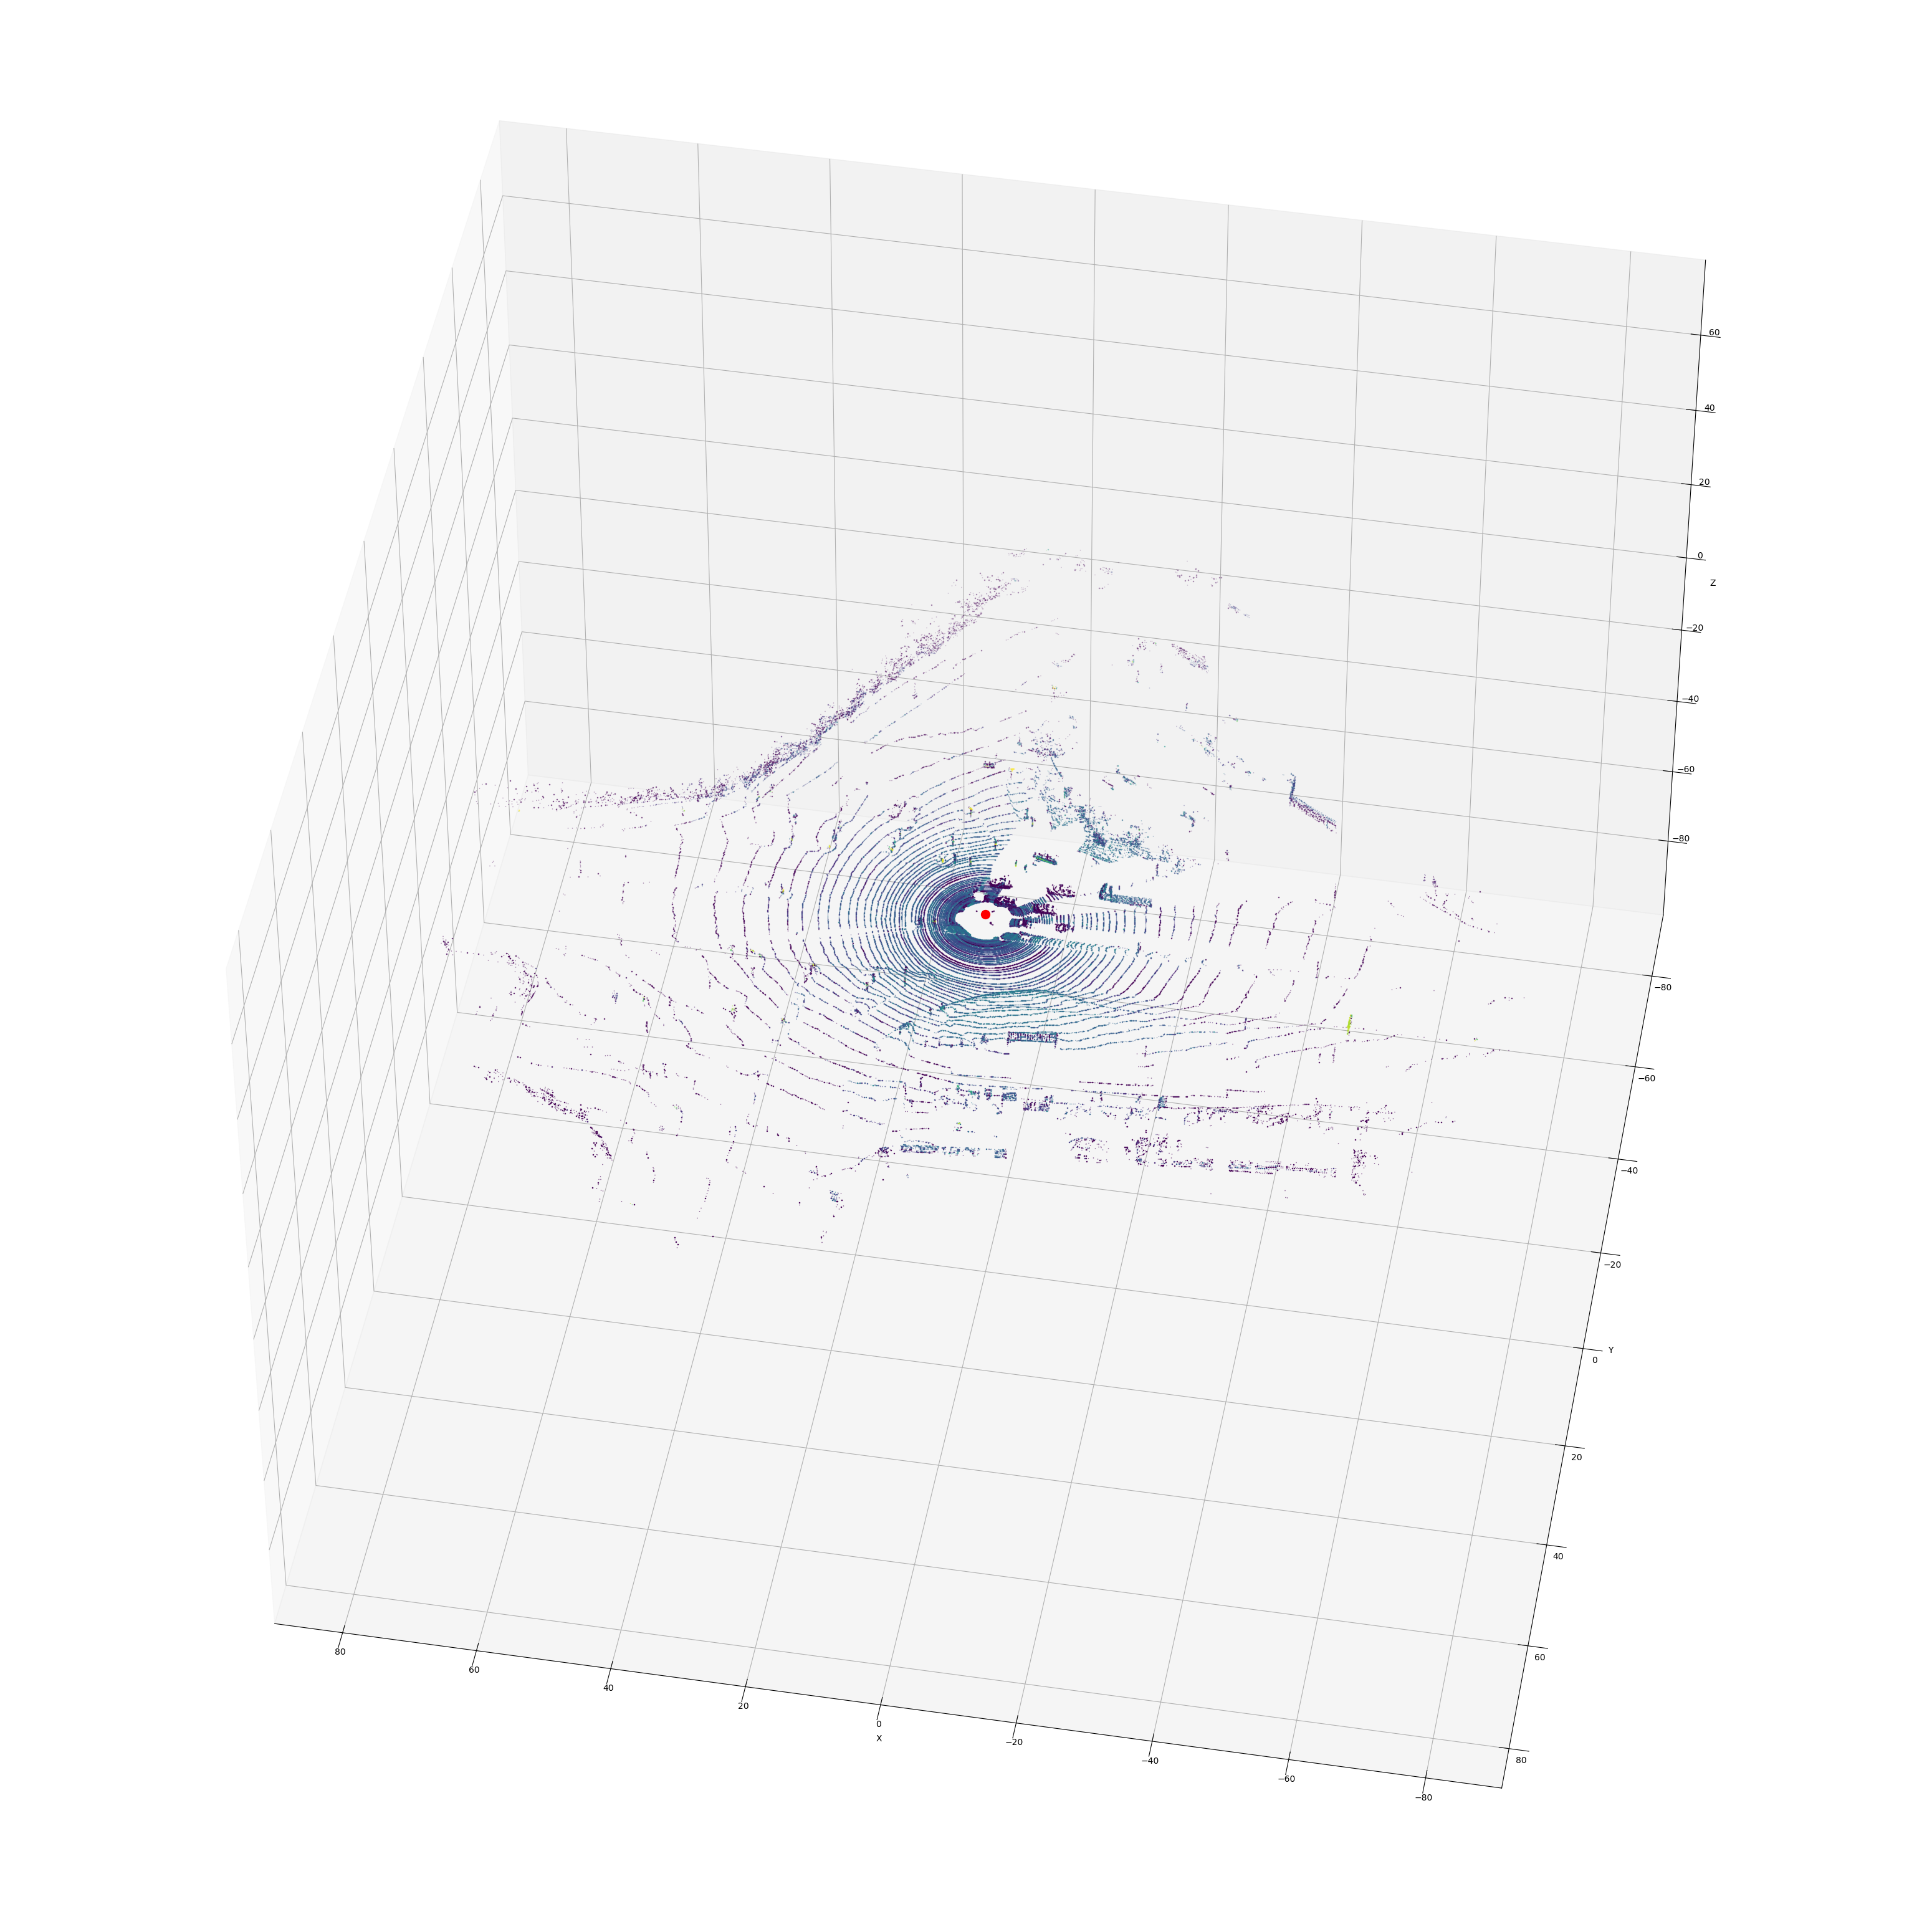

<Figure size 640x480 with 0 Axes>

In [8]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')
ax.scatter(0, 0, 0, s=100, c='red', marker='o')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=45, azim=100) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()
plt.savefig('test.png')

## Convert to azimuth, height, distance format

In [10]:
def convert_points_to_polar(bin_file_path):
    # Load point cloud data from .bin file
    num_points = 4  # x, y, z, intensity
    data = np.fromfile(bin_file_path, dtype=np.float32)
    points = data.reshape(-1, num_points)

    # Calculate azimuth in degrees
    azimuth = np.degrees(np.arctan2(points[:, 1], points[:, 0]))

    # Calculate elevation in degrees
    elevation = np.degrees(np.arctan2(points[:, 2], np.sqrt(points[:, 0]**2 + points[:, 1]**2)))

    # Calculate distance
    distance = np.sqrt(np.sum(points[:, :3]**2, axis=1))

    # Create a DataFrame
    df = pd.DataFrame({
        'Azimuth': azimuth,
        'Elevation': elevation,
        'Distance': distance,
        'Intensity': points[:, 3]
    })

    return df

## What is the distance measured in?

In [12]:
# Usage
polar_df = convert_points_to_polar(bin_path)
print(polar_df.head())

    Azimuth  Elevation   Distance  Intensity
0  0.098019   2.302210  32.760494       0.23
1  0.277548   2.301179  32.849876       0.00
2  0.458117   2.305173  32.544376       0.00
3  0.929024   2.136147  60.175720       0.00
4  1.109021   2.135864  60.130028       0.00


In [13]:
polar_df.describe()

,Azimuth,Elevation,Distance,Intensity
count,116644.000000,116644.000000,116644.000000,116644.000000
mean,4.337594,-9.234881,17.614801,0.215773
std,99.593727,7.052813,16.037220,0.143751
min,-180.000000,-24.227907,1.462862,0.000000
25%,-79.840439,-15.118146,6.063750,0.110000
50%,7.506324,-8.366051,10.986212,0.250000
75%,90.657705,-3.437263,23.127408,0.310000
max,180.000000,3.550540,80.004280,0.990000


In [14]:
# Next steps
# Superimpose all frames into one frame
# Take farthest points

# Divide the vectors into a sort of grid.
# any point can be mapped to it's grid location by "rounding down" to the nearest indicating coordinates

# So make a background map out of all of these points.
# I make a dataframe with each bottom left corner of the grid.
# The I go through each binary file, and for each point, I map it to the grid (by rounding down)
# Each grid square will have a list of distances. I can get the median of the distance for each grid, and the max
# I'll take the median map and the max map and change them back into x,y,z coordinates (maybe take the average of the intensities?)
# And display the map to see what it looks like

# For each point that I'm checking against the background map, I can "round up" to the "top corner" of the square cone.

# Try to make a background map

## Create a "grid" for points
And a dataframe for that grid

In [17]:
# Create the grid DataFrames
def create_grid_dataframes(azimuth_map, height_map):
    grid_shape = (len(height_map), len(azimuth_map))
    df_distances = pd.DataFrame({key: [[] for _ in range(len(height_map))] for key in azimuth_map.keys()}, index=height_map.keys())
    df_intensities = pd.DataFrame({key: [[] for _ in range(len(height_map))] for key in azimuth_map.keys()}, index=height_map.keys())
    return df_distances, df_intensities

In [18]:
# Create mappings for azimuth and height using integers
def create_mappings(azimuth_step=azimuth_resolution, height_step=height_resolution):
    azimuth_range = np.arange(-180, 180 + azimuth_step, azimuth_step)
    height_range = np.arange(-30, 10 + height_step, height_step)
    azimuth_map = {int(az * 10): idx for idx, az in enumerate(azimuth_range)}
    height_map = {int(ht * 10): idx for idx, ht in enumerate(height_range)}
    return azimuth_map, height_map

## Populate the grid
By going through each frame and mapping each point to the grid

In [20]:
# Process file into grid
def process_file_to_grid(file_path, df_distances, df_intensities, azimuth_map, height_map):
    data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    for x, y, z, intensity in data:
        distance = np.sqrt(x**2 + y**2 + z**2)
        azimuth = np.degrees(np.arctan2(y, x))
        height = np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))
        # Convert and scale
        azimuth_idx = int(np.floor((azimuth + 180) / azimuth_resolution) * azimuth_resolution * 10) - 1800
        height_idx = int(np.floor((height + 30) / height_resolution)) - 300
        # Update DataFrames directly using indices
        if azimuth_idx in azimuth_map and height_idx in height_map:
            df_distances.at[height_idx, azimuth_idx].append(distance)
            df_intensities.at[height_idx, azimuth_idx].append(intensity)

In [21]:
# Function to process a single file into a DataFrame
# def process_file_to_df(file_path):
#     print('processing file, converting to polar, and rounding')
#     data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
#     df = pd.DataFrame(data, columns=['x', 'y', 'z', 'intensity'])
#     df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
#     df['azimuth'] = np.degrees(np.arctan2(df['y'], df['x']))
#     df['height'] = np.degrees(np.arctan2(df['z'], np.sqrt(df['x']**2 + df['y']**2)))
#     df['azimuth'] = np.floor((df['azimuth'] + 180) / 0.5) * 0.5 - 180
#     df['height'] = np.floor((df['height'] + 30) / 0.1) * 0.1 - 30
#     return df

In [22]:
# Function to update the grid DataFrame using the data DataFrame
def update_grid(df_grid, df_data):
    print('updating background map grid')
    # Group by azimuth and height and aggregate lists
    grouped = df_data.groupby(['azimuth', 'height']).agg(list).reset_index()
    for index, row in grouped.iterrows():
        mask = (df_grid['Azimuth'] == row['azimuth']) & (df_grid['Height'] == row['height'])
        if not df_grid.loc[mask, 'Distances'].empty:
            df_grid.loc[mask, 'Distances'].iloc[0].extend(row['distance'])
            df_grid.loc[mask, 'Intensities'].iloc[0].extend(row['intensity'])

In [23]:
# Main function
def process_all_files(directory_path):
    azimuth_map, height_map = create_mappings()
    df_distances, df_intensities = create_grid_dataframes(azimuth_map, height_map)
    files = [f for f in os.listdir(directory_path) if f.endswith('.bin')]
    for filename in files[:50]:  # Process only the first 10 files
        print('processing file: ' + filename)
        file_path = os.path.join(directory_path, filename)
        process_file_to_grid(file_path, df_distances, df_intensities, azimuth_map, height_map)
    return df_distances, df_intensities

In [24]:
directory_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data'
df_distances, df_intensities = process_all_files(directory_path)
# print(df_distances)
# print(df_intensities)

processing file: 0000000071.bin
processing file: 0000000004.bin
processing file: 0000000011.bin
processing file: 0000000091.bin
processing file: 0000000031.bin
processing file: 0000000003.bin
processing file: 0000000014.bin
processing file: 0000000081.bin
processing file: 0000000048.bin
processing file: 0000000111.bin
processing file: 0000000112.bin
processing file: 0000000083.bin
processing file: 0000000096.bin
processing file: 0000000074.bin
processing file: 0000000089.bin
processing file: 0000000047.bin
processing file: 0000000025.bin
processing file: 0000000030.bin
processing file: 0000000072.bin
processing file: 0000000052.bin
processing file: 0000000098.bin
processing file: 0000000055.bin
processing file: 0000000038.bin
processing file: 0000000046.bin
processing file: 0000000109.bin
processing file: 0000000037.bin
processing file: 0000000065.bin
processing file: 0000000049.bin
processing file: 0000000110.bin
processing file: 0000000069.bin
processing file: 0000000002.bin
processi

In [25]:
df_distances.describe()

,-1800,-1790,-1780,-1770,-1760,-1750,-1740,-1730,-1720,-1710,...,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800
count,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
unique,9,8,8,8,8,8,8,8,8,9,...,8,8,9,8,7,9,9,8,8,5
top,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
freq,73,74,74,74,74,74,74,74,74,73,...,74,74,73,74,75,73,73,74,74,77


In [26]:
df_distances

,-1800,-1790,-1780,-1770,-1760,-1750,-1740,-1730,-1720,-1710,...,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800
-300,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
-295,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
-290,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
-285,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
-280,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
85,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
90,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
95,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [27]:
def calculate_std_deviation(df):
    # Initialize a list to store the standard deviations
    std_deviations = []

    # Iterate through each cell in the DataFrame
    for value in df.stack():
        if value:  # Check if the list is not empty
            std_deviations.append(np.std(value))

    std_deviations_series = pd.Series(std_deviations)
    return std_deviations_series

In [28]:
std_devs = calculate_std_deviation(df_distances)

In [29]:
# Describe the standard devations of all the distance lists- std devs are used for adjusting the sensitivity of the background map
std_devs.describe()

count    3223.000000
mean        1.557472
std         3.374802
min         0.000000
25%         0.008979
50%         0.116601
75%         1.373695
max        29.399487
dtype: float64

In [502]:
std_dev_cutoff = 1.5

In [503]:
def create_background_lookup_table(df_distances):
    # Create a new DataFrame with the same index and columns as df_distances
    lookup_table = pd.DataFrame(index=df_distances.index, columns=df_distances.columns)
    num_distances = 0
    # Iterate through each cell in df_distances
    for (height, azimuth), distances in df_distances.stack().items():
        if distances:  # If the list is not empty
            # Calculate the value as the largest distance minus the standard deviation
            # value = np.max(distances) - (2 * np.std(distances))
            cutoff = np.max(distances)
            standard_deviation = np.std(distances)
            adjustment = standard_deviation / 2
            
            # If the points are tightly packed, this is probably a background area, set really close
            if standard_deviation < std_dev_cutoff:
                cutoff = 1
            # If they are not, then be stricter (farther away) with the background
            else:
                num_distances += 1
#                 print('Distance: ' + str(max_distance))
#                 print('Standard deviation: ' + str(standard_deviation))
                
                cutoff = cutoff - adjustment
                
#                 print('adjusted distance: ' + str(max_distance))
#                 print()
#                 print()
#                 print()
            value = cutoff
        else:
            value = np.nan  # If the list is empty, set the cell to NaN

        # Set the value in the new DataFrame
        lookup_table.at[height, azimuth] = value

    print(num_distances)
    return lookup_table

In [504]:
distance_lookup_table = create_background_lookup_table(df_distances)

758


## Use the grid point lists to make background maps

In [506]:
# Function to create the background map DataFrame
def create_background_map(df_distances, df_intensities):
    # Initialize a list to store each row (as a dictionary) before creating the DataFrame
    data = []

    # Iterate through each cell in df_distances
    for (height, azimuth), distances in df_distances.stack().items():
        if distances:  # Make sure there are distances recorded in the cell
            # Get the corresponding intensities
            intensities = df_intensities.at[height, azimuth]
            
            # Calculate the median distance and average intensity
            distance = np.max(distances) - np.std(distances)
            average_intensity = np.mean(intensities)

            # Prepare a dictionary for the new row
            new_row = {
                'Azimuth': azimuth / 10,  # Convert back to original scale
                'Height': height / 10,    # Convert back to original scale
                'Distance': distance,
                'Average Intensity': average_intensity
            }
            data.append(new_row)

    # Create the DataFrame from the list of dictionaries
    background_map = pd.DataFrame(data)
    return background_map

In [507]:
background_map_df = create_background_map(df_distances, df_intensities)
print(background_map_df.head())

   Azimuth  Height  Distance  Average Intensity
0   -150.0   -28.5  4.779596           0.000000
1   -149.0   -28.5  4.774327           0.046700
2   -148.0   -28.5  4.765486           0.154094
3   -147.0   -28.5  4.766603           0.164334
4   -146.0   -28.5  4.758987           0.186246


In [508]:
background_map_df.describe()

,Azimuth,Height,Distance,Average Intensity
count,3223.000000,3223.000000,3223.000000,3223.000000
mean,-2.135278,-26.023581,16.531496,0.205704
std,102.052443,1.338527,15.528059,0.114799
min,-180.000000,-28.500000,2.057061,0.000000
25%,-93.000000,-27.000000,6.399166,0.121392
50%,-2.000000,-26.000000,9.750321,0.221675
75%,85.000000,-25.000000,19.565101,0.296661
max,180.000000,-23.500000,78.708031,0.881597


In [509]:
csv_filename = 'background_map.cvs'
background_map_df.to_csv(csv_filename, index=False)

## Display background maps

In [511]:
def get_xyz_format(df):
    df_copy = df.copy()

    # Convert degrees to radians
    df_copy['Azimuth'] = np.radians(df_copy['Azimuth'])
    df_copy['Height'] = np.radians(df_copy['Height'])

    # Convert spherical to Cartesian coordinates
    df_copy['x'] = df_copy['Distance'] * np.cos(df_copy['Height']) * np.cos(df_copy['Azimuth'])
    df_copy['y'] = df_copy['Distance'] * np.cos(df_copy['Height']) * np.sin(df_copy['Azimuth'])
    df_copy['z'] = df_copy['Distance'] * np.sin(df_copy['Height'])

    # Create a new DataFrame with the required format
    cartesian_format = pd.DataFrame({
        'x': df_copy['x'],
        'y': df_copy['y'],
        'z': df_copy['z'],
        'Intensity': df_copy['Average Intensity']
    })
    
    return cartesian_format

In [512]:
new_cartesian_format = get_xyz_format(background_map_df)
print(new_cartesian_format)

             x          y         z  Intensity
0    -3.637645  -2.100195 -2.280626   0.000000
1    -3.596469  -2.160976 -2.278112   0.046700
2    -3.551617  -2.219297 -2.273893   0.154094
3    -3.513168  -2.281478 -2.274426   0.164334
4    -3.467267  -2.338701 -2.270793   0.186246
...        ...        ...       ...        ...
3218  8.768451  12.068737 -6.486435   0.212522
3219  8.555824  14.239282 -7.223113   0.176937
3220  4.387980  19.006430 -8.481614   0.110000
3221  4.047365  19.041355 -8.464384   0.194167
3222  2.826885  17.848248 -7.857376   0.325446

[3223 rows x 4 columns]


In [513]:
new_cartesian_format.describe()

,x,y,z,Intensity
count,3223.000000,3223.000000,3223.000000,3223.000000
mean,-0.145256,-0.152348,-7.000172,0.205704
std,14.459891,14.733596,6.266305,0.114799
min,-67.719724,-69.619851,-34.412668,0.000000
25%,-5.378845,-5.479001,-8.188037,0.121392
50%,0.157305,-0.087312,-4.273859,0.221675
75%,5.569031,5.550031,-2.902080,0.296661
max,70.503519,64.691179,-0.981545,0.881597


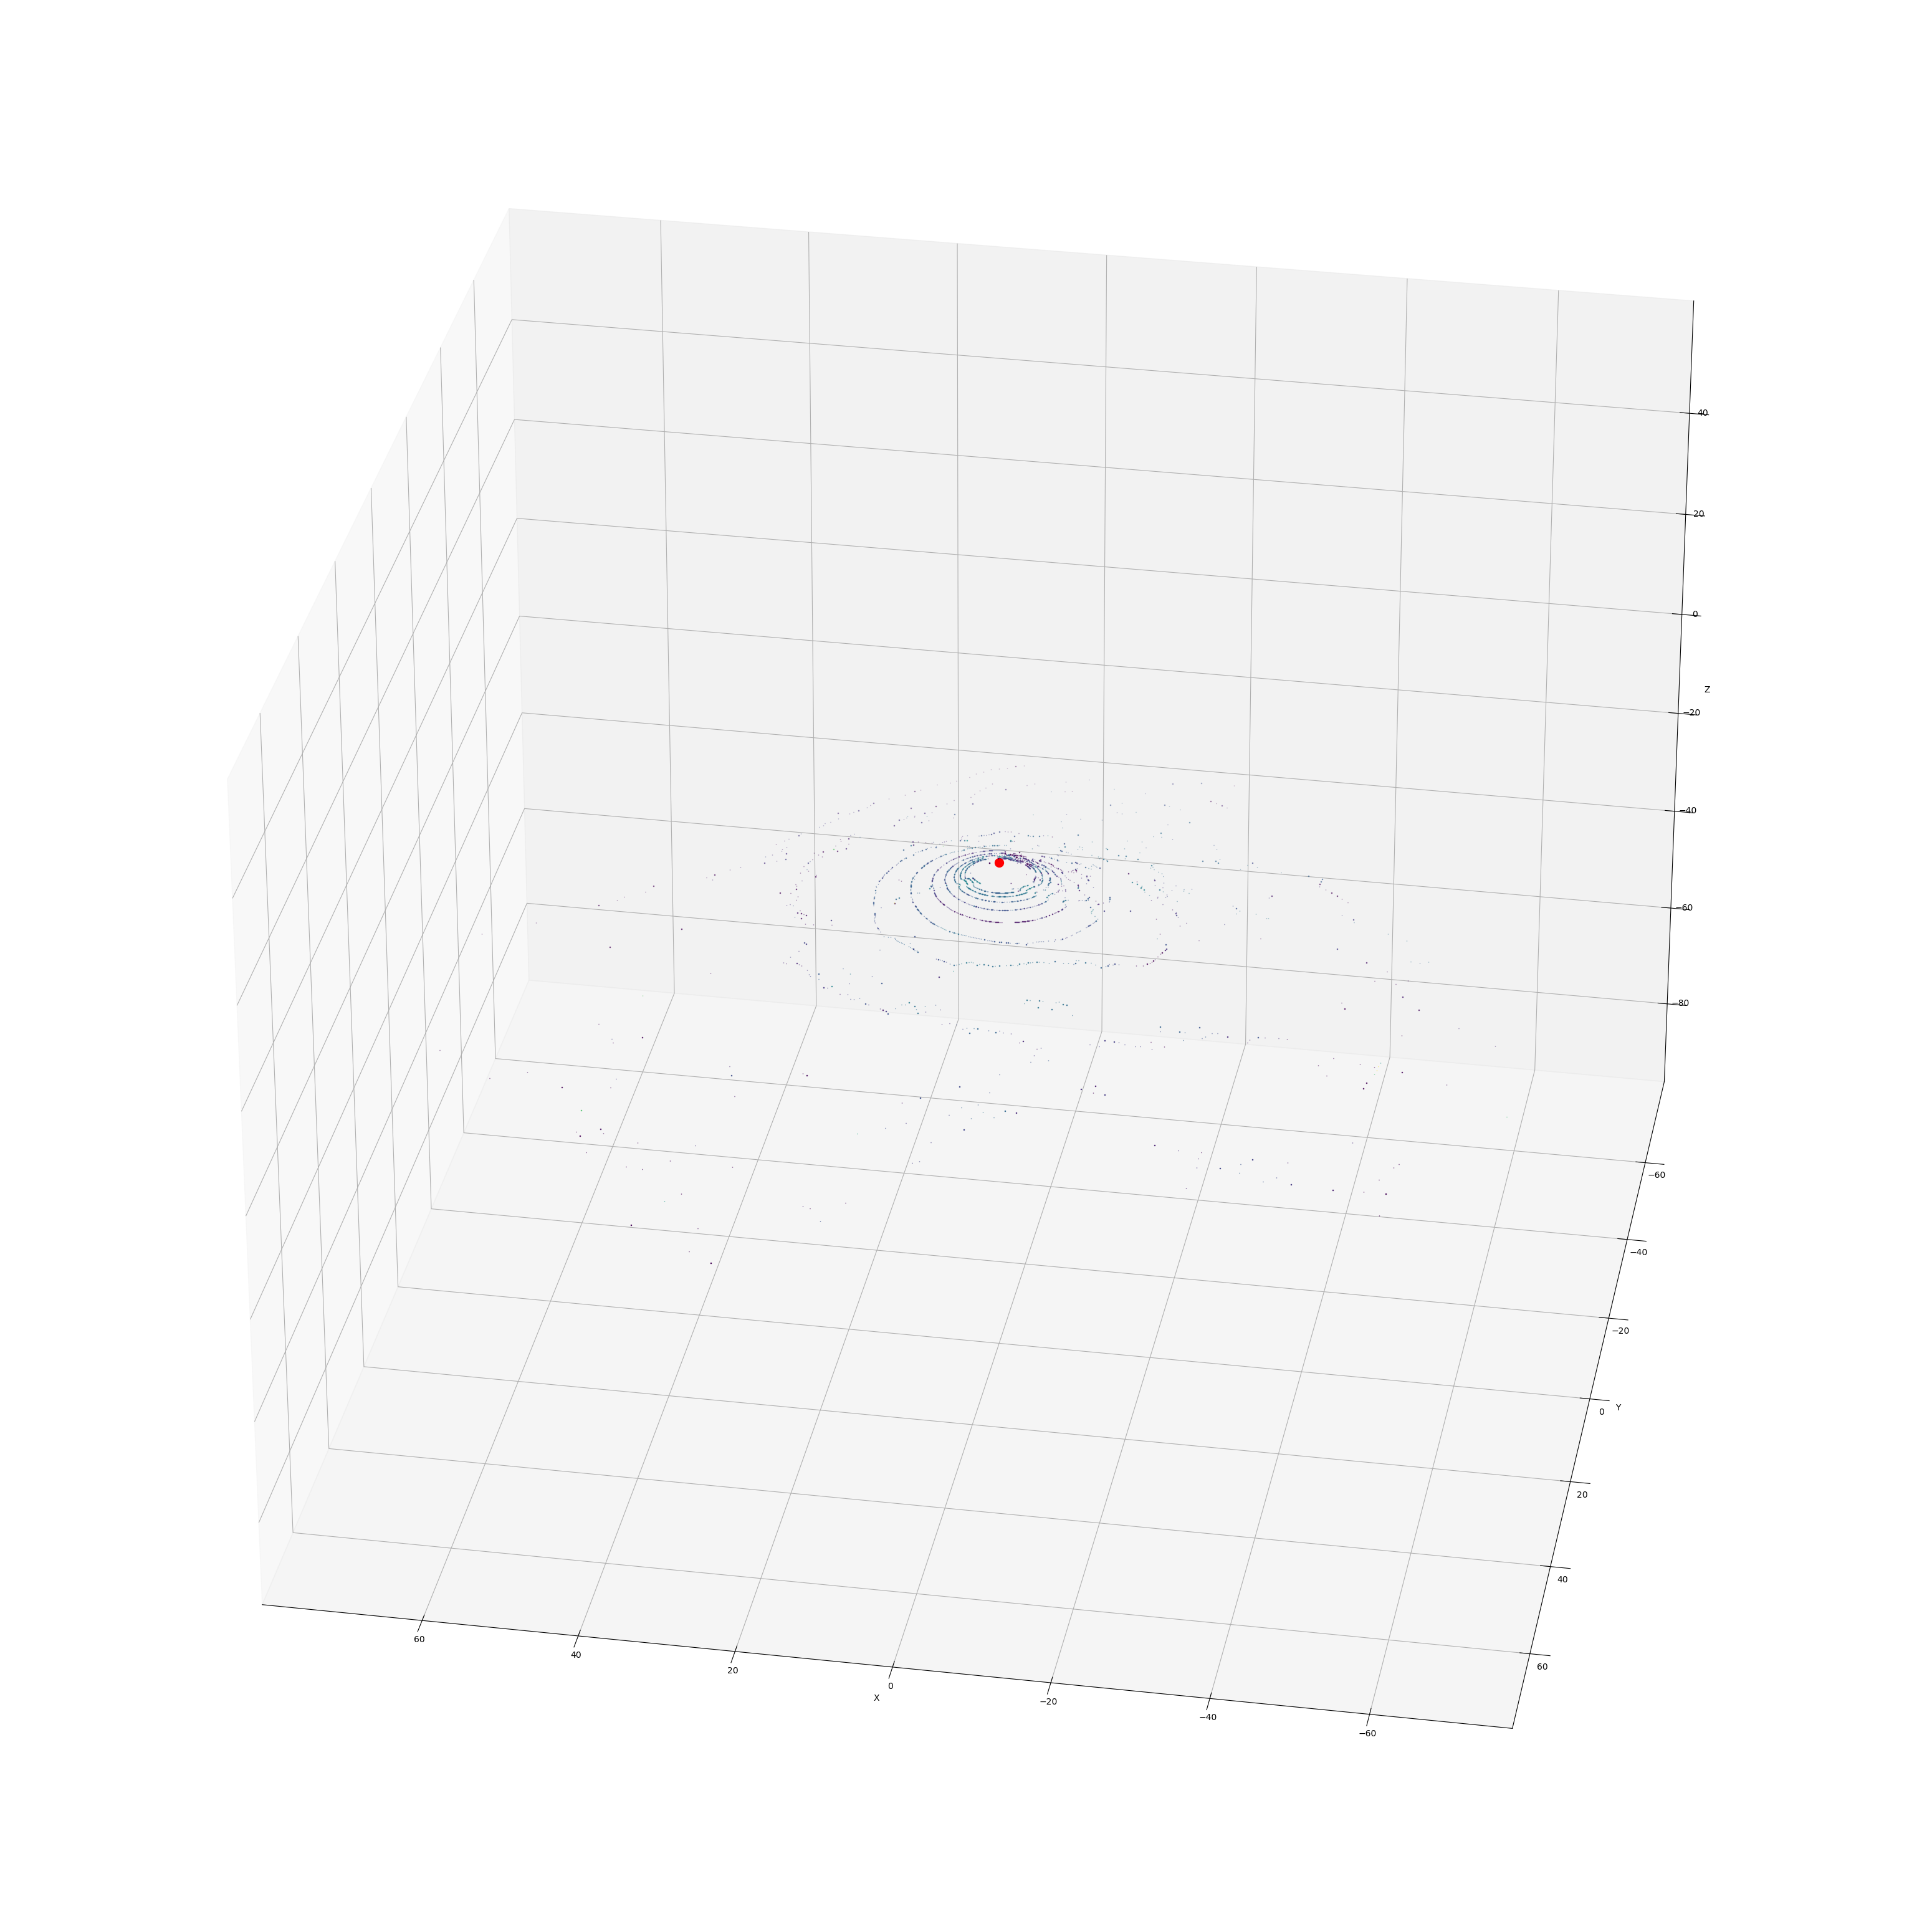

In [514]:
# from mpl_toolkits.mplot3d import Axes3D

# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud using DataFrame column names
ax.scatter(
    new_cartesian_format['x'], 
    new_cartesian_format['y'], 
    new_cartesian_format['z'], 
    s=0.1, 
    c=new_cartesian_format['Intensity'], 
    cmap='viridis', 
    marker=','
)

ax.scatter(0, 0, 0, s=100, c='red', marker='o')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=30, azim=100)

set_axes_equal(ax)  # Ensure the aspect ratio is equal

plt.show()

In [515]:
from ipywidgets import interact, widgets

# Function to update the plot based on the azimuth and elevation
def update_plot(azim, elev):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        new_cartesian_format['x'],
        new_cartesian_format['y'],
        new_cartesian_format['z'],
        c=new_cartesian_format['Intensity'],
        s=0.01,
        cmap='viridis',
        marker=','
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    set_axes_equal(ax)  # Ensure the aspect ratio is equal
    plt.show()

# Create sliders for azimuth and elevation
azim_slider = widgets.IntSlider(min=-180, max=180, step=1, value=0, description='Azimuth')
elev_slider = widgets.IntSlider(min=-90, max=90, step=1, value=30, description='Elevation')
zoom_slider = widgets.FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='Zoom')

# Display the interactive plot
interact(update_plot, azim=azim_slider, elev=elev_slider)

interactive(children=(IntSlider(value=0, description='Azimuth', max=180, min=-180), IntSlider(value=30, descri…

<function __main__.update_plot(azim, elev)>

## Try filtering

In [517]:
# Filter frame
# Load point cloud data
bin_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data/0000000100.bin'
pre_filtered_data = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [518]:
pre_filtered_data

array([[32.734,  0.056,  1.316,  0.23 ],
       [32.823,  0.159,  1.319,  0.   ],
       [32.517,  0.26 ,  1.309,  0.   ],
       ...,
       [ 3.711, -1.403, -1.734,  0.   ],
       [ 3.722, -1.394, -1.737,  0.   ],
       [ 3.754, -1.393, -1.751,  0.   ]], dtype=float32)

In [519]:
# Make pre-filtered points into a dataframe
def convert_to_dataframe(data):
    columns = ['x', 'y', 'z', 'intensity']
    df = pd.DataFrame(data, columns=columns)
    return df

In [520]:
def add_lookup_coords_to_xyz(points_df):
    # Calculate the distance, azimuth, and height using vectorized operations
    x, y, z, intensity = points_df['x'], points_df['y'], points_df['z'], points_df['intensity']
    distance = np.sqrt(x**2 + y**2 + z**2)
    azimuth = np.degrees(np.arctan2(y, x))
    height = np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))
    
    # Convert and scale
    azimuth_idx = np.floor((azimuth + 180) / azimuth_resolution).astype(int) * azimuth_resolution * 10 - 1800
    height_idx = np.floor((height + 30) / height_resolution).astype(int) - 300
    
    
    # azimuth_idx = int(np.floor((azimuth + 180) / 0.5) * 0.5 * 10) - 1800
    # height_idx = int(np.floor((height + 30) / 0.1) * 0.1 * 10) - 300
    # Add new columns to dataframe
    points_df['distance'] = distance
    points_df['azimuth_idx'] = azimuth_idx
    points_df['height_idx'] = height_idx
    
    return points_df

In [521]:
#covert to dataframe
pre_filtered_points = convert_to_dataframe(pre_filtered_data)
# convert to grid lookup format
pre_filtered_grid_lookup = add_lookup_coords_to_xyz(pre_filtered_points)

In [522]:
pre_filtered_grid_lookup

,x,y,z,intensity,distance,azimuth_idx,height_idx
0,32.734001,0.056,1.316,0.23,32.760494,0,-236
1,32.823002,0.159,1.319,0.00,32.849876,0,-236
2,32.516998,0.260,1.309,0.00,32.544376,0,-236
3,60.125999,0.975,2.243,0.00,60.175720,0,-236
4,60.077000,1.163,2.241,0.00,60.130028,10,-236
...,...,...,...,...,...,...,...
116639,3.709000,-1.429,-1.737,0.00,4.337729,-220,-288
116640,3.712000,-1.417,-1.737,0.00,4.336358,-210,-288
116641,3.711000,-1.403,-1.734,0.00,4.329744,-210,-288
116642,3.722000,-1.394,-1.737,0.00,4.337475,-210,-288


- make a background filtering function


In [524]:
def filter_points(df_input, lookup_table):
    # Initialize a list to store rows that meet the criteria
    filtered_data = []

    # Iterate through each row in the input DataFrame
    # for idx, row in df_input.iloc[:10].iterrows():
    for idx, row in df_input.iterrows():
        azimuth_idx = int(row['azimuth_idx'])
        height_idx = int(row['height_idx'])
        
        # Check if the indices exist in the lookup table and the value is not NaN
        if azimuth_idx in lookup_table.columns and height_idx in lookup_table.index:
            # print('.', end='')
            lookup_value = lookup_table.at[height_idx, azimuth_idx]
            
            if not pd.isna(lookup_value) and row['distance'] < lookup_value:
                # If criteria are met, add the row's x, y, z, and intensity to the filtered_data list
                filtered_data.append({
                    'x': row['x'],
                    'y': row['y'],
                    'z': row['z'],
                    'intensity': row['intensity']
                })

    # Create a DataFrame from the filtered data
    filtered_df = pd.DataFrame(filtered_data)
    return filtered_df

In [525]:
filtered_df = filter_points(pre_filtered_grid_lookup, distance_lookup_table)

In [526]:
filtered_df

,x,y,z,intensity
0,35.172001,13.769000,0.326,0.78
1,35.214001,13.849000,0.326,0.00
2,63.421001,28.438000,0.426,0.00
3,62.563999,28.290001,0.423,0.00
4,62.841000,28.653000,0.425,0.00
...,...,...,...,...
3138,-0.831000,1.108000,-0.499,0.00
3139,-0.845000,1.124000,-0.509,0.00
3140,-0.822000,-1.137000,-0.507,0.00
3141,-0.836000,-1.174000,-0.524,0.00


In [527]:


# For point in pre_filtered_grid_lookup
    # Check the corresponding cell in the background map
    # If the list there is not empty
        # 

# if the grid distance is greater than the point's distance
# then add it to the new, filtered dataframe

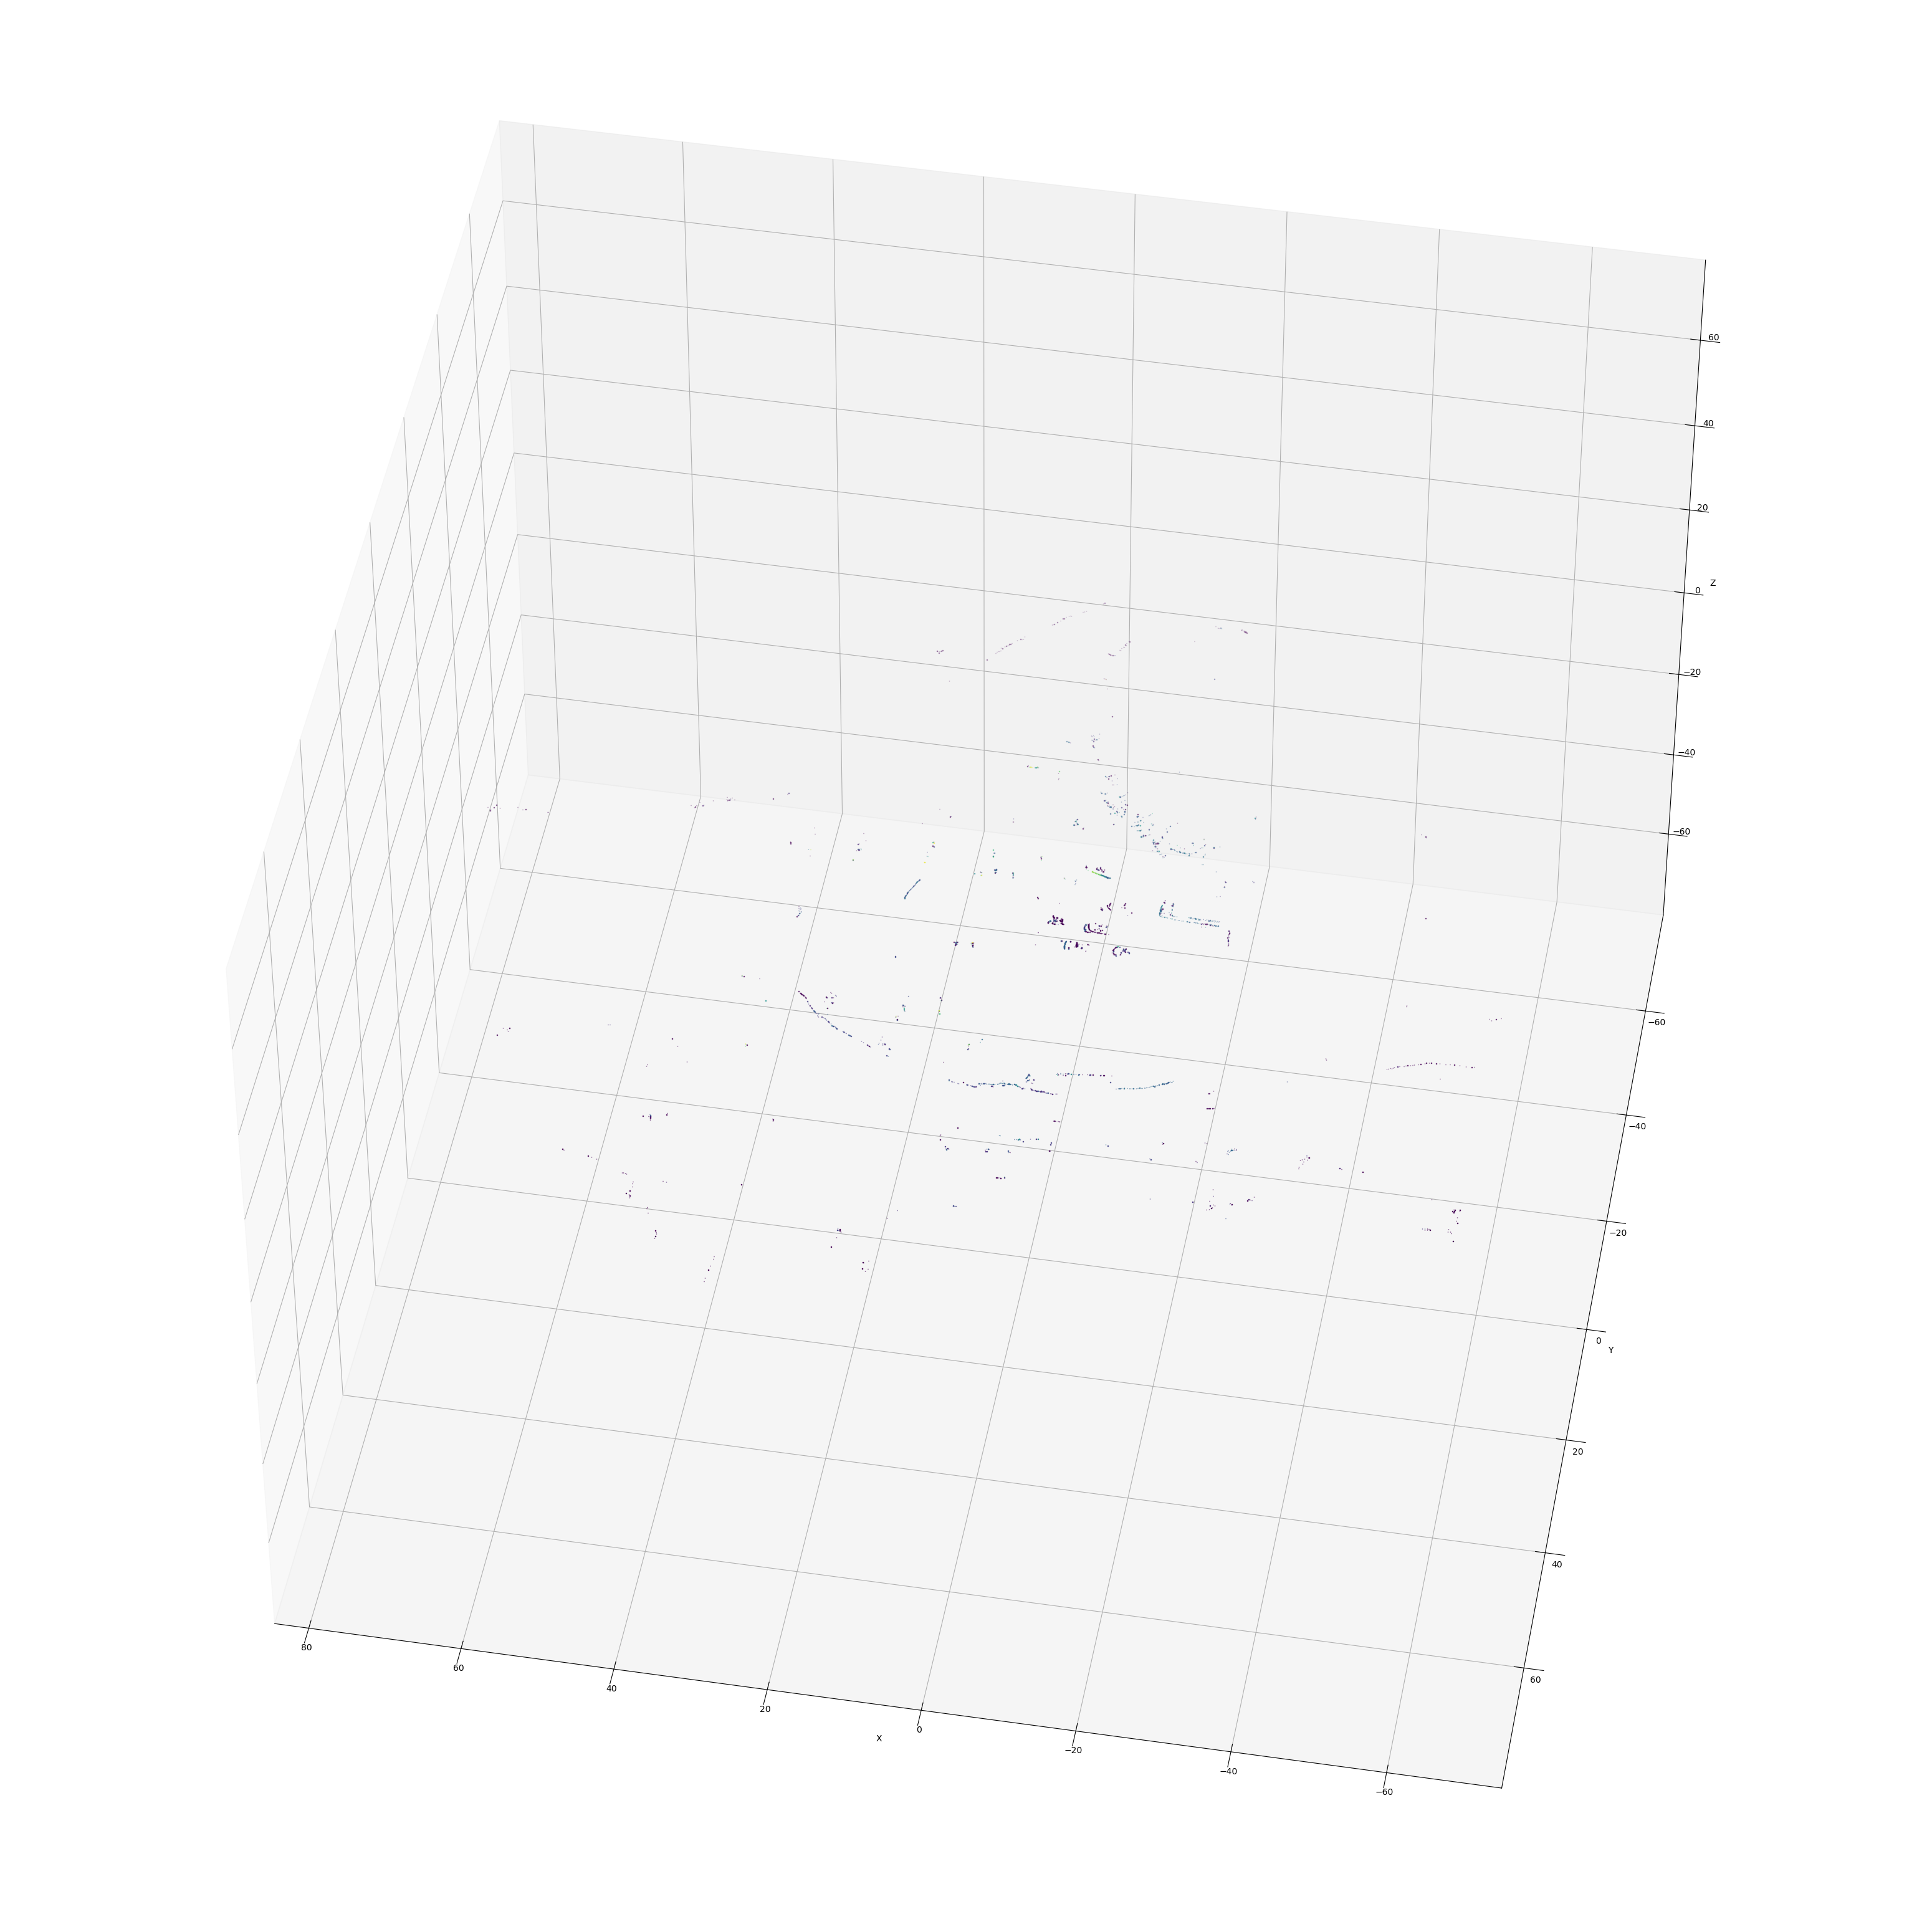

In [528]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(filtered_df['x'], filtered_df['y'], filtered_df['z'], s=0.1, c=filtered_df['intensity'], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=45, azim=100) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()